In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
train_path = 'birds/train'
valid_path =  'birds/valid'
test_path = 'birds/test'

Number of classes: 525


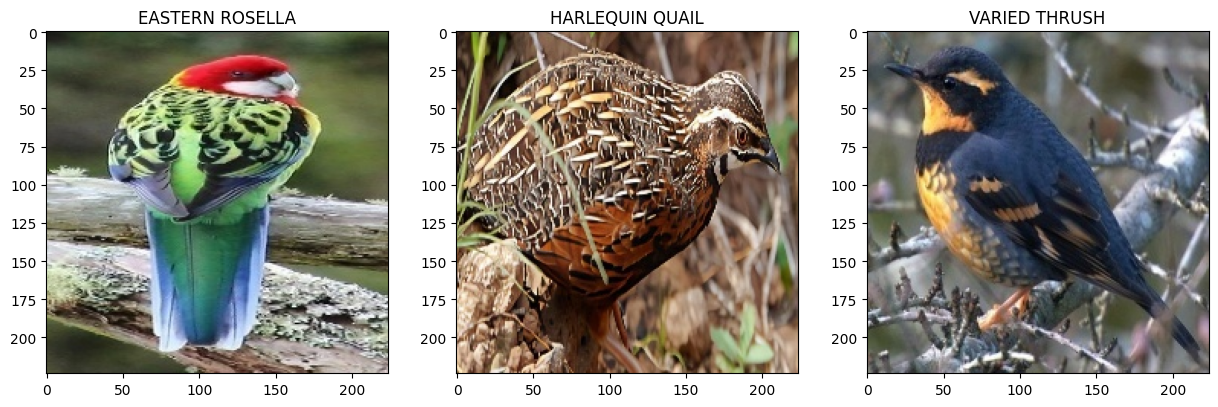

In [3]:
print(f'Number of classes: {len(os.listdir("birds/train"))}')
def plot_random_image():
    random_class = random.sample(os.listdir(train_path), 1)
    random_img = random.sample(os.listdir(train_path + '/' + random_class[0]), 1)
    img = mpimg.imread(train_path + '/' + random_class[0] + '/' + random_img[0])

    plt.imshow(img)
    plt.title(random_class[0])
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plot_random_image()

plt.subplot(2,3,2)
plot_random_image()

plt.subplot(2,3,3)
plot_random_image()


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
image_size = (224, 224)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [6]:

model = Sequential([
    layers.Conv2D(32, 3, strides=2, padding='same', activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.SeparableConv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.SeparableConv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.SeparableConv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(525, activation='softmax'), 
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                                 
 separable_conv2d (Separabl  (None, 112, 112, 128)     8896      
 eConv2D)                                                        
                                                        

In [7]:
checkpoint_path = "checkpoints"

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True,
    verbose=0
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=0
)

In [8]:
lr = 0.002
epochs = 15

model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(lr),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [9]:
History = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
2645/2645 [==============================] - ETA: 0s - loss: 5.5194 - accuracy: 0.0526INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


2645/2645 [==============================] - 1678s 634ms/step - loss: 5.5194 - accuracy: 0.0526 - val_loss: 3.7194 - val_accuracy: 0.2160
Epoch 2/15
2645/2645 [==============================] - ETA: 0s - loss: 3.7567 - accuracy: 0.1982INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


2645/2645 [==============================] - 1644s 622ms/step - loss: 3.7567 - accuracy: 0.1982 - val_loss: 2.5315 - val_accuracy: 0.4114
Epoch 3/15
2645/2645 [==============================] - ETA: 0s - loss: 3.0275 - accuracy: 0.3137INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


2645/2645 [==============================] - 1740s 658ms/step - loss: 3.0275 - accuracy: 0.3137 - val_loss: 2.0990 - val_accuracy: 0.4903
Epoch 4/15
2493/2645 [===========================>..] - ETA: 1:36 - loss: 2.6384 - accuracy: 0.3876